# Baumgarte - Numerical Relativity
## Problem 4.5

In [1]:
from sympy import *
init_printing(use_unicode=True)

In [2]:
r, theta, phi = symbols('r, \\theta, \phi')
M = symbols('M')
psi = Function(Symbol('\psi', real=True))
coords = [ r, theta, phi ]

In [7]:
def compute_christoffel(metric):
    if metric.shape != (3, 3):
        raise Exception("Invalid dimensions")

    inv_metric = metric.inv()
    
    out = []
    for i in range(0, 3):
        rows = []
        for j in range(0, 3):
            row = []
            for k in range(0, 3):
                res = 0.0
                for l in range(0, 3):
                    res += inv_metric[i, l] * (
                        Derivative(metric[l, j], coords[k]) +
                        Derivative(metric[l, k], coords[j]) -
                        Derivative(metric[j, k], coords[l]))
                row.append(res / 2)
            rows.append(row)
        out.append(Matrix(rows).applyfunc(simplify))
    return out

def compute_ricci(christoffel):
    if len(christoffel) != 3 or christoffel[0].shape != (3, 3):
        raise Exception("Invalid dimensions")
    rows = []
    for i in range(0, 3):
        row = []
        for j in range(0, 3):
            res = 0.0
            for k in range(0, 3):
                res += Derivative(christoffel[k][i, j], coords[k])
                res -= Derivative(christoffel[k][k, j], coords[i])
                for l in range(0, 3):
                    res += christoffel[k][i, j] * christoffel[l][k, l]
                    res -= christoffel[k][i, l] * christoffel[l][j, k]
            row.append(res)
        rows.append(row)
    return Matrix(rows).applyfunc(simplify)

def compute_trace(matrix_lo, inv_metric):
    return simplify(matrix_lo[0, 0] * inv_metric[0, 0] +
                    matrix_lo[1, 1] * inv_metric[1, 1] +
                    matrix_lo[2, 2] * inv_metric[2, 2])

# Compute covariant derivative of rank-0 tensor
def compute_diff_scalar(s, christoffel):
    if len(christoffel) != 3:
        raise Exception('Invalid dimensions')

    return Matrix([ diff(s, x) for x in coords ]).applyfunc(simplify)

# Compute covariant derivative of rank-1 covariant tensor
def compute_diff_vec_lo(t, christoffel):
    if len(t) != 3 or len(christoffel) != 3:
        raise Exception('Invalid dimensions')

    rows = []
    for i in range(0, 3):
        row = []
        for j in range(0, 3):
            res = diff(t[i], coords[j])
            for k in range(0, 3):
                res -= christoffel[k][i, j] * t[k]
            row.append(res)
        rows.append(row)
    return Matrix(rows).applyfunc(simplify)

# Compute covariant derivative of rank-2 covariant tensor
def compute_diff_matrix_lo(m, christoffel):
    if m.shape != (3, 3) or len(christoffel) != 3:
        raise Exception('Invalid dimensions')

    out = []
    for i in range(0, 3):
        rows = []
        for j in range(0, 3):
            row = []
            for k in range(0, 3):
                res = diff(m[j, k], coords[i])
                for l in range(0, 3):
                    res -= christoffel[l][i, j] * m[l, k]
                    res -= christoffel[l][i, k] * m[j, l]
                row.append(res)
            rows.append(row)
        out.append(Matrix(rows).applyfunc(simplify))
    return out

def compute_laplacian(scalar, metric):
    christoffel = compute_christoffel(metric)
    vec_lo = compute_diff_scalar(scalar, christoffel)
    twoform = compute_diff_vec_lo(vec_lo, christoffel)
    return compute_trace(twoform, metric.inv())

#### Checking Schwartzschild metric

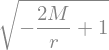

In [8]:
sch_alpha = sqrt(1 - 2 * M / r)
sch_alpha

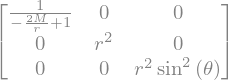

In [9]:
sch_metric = Matrix([
    [ 1 / (1 - 2 * M / r), 0, 0 ],
    [ 0, r ** 2, 0 ],
    [ 0, 0, r ** 2 * sin(theta) ** 2 ]
])
sch_metric

In [10]:
compute_laplacian(sch_alpha, sch_metric)

#### Checking Isotropic metric

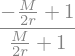

In [11]:
iso_alpha = (1 - M / (2 * r)) / (1 + M / (2 * r))
iso_alpha

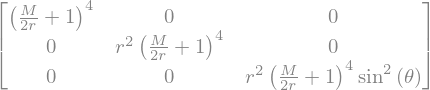

In [12]:
iso_metric = Matrix([
    [ 1, 0, 0 ],
    [ 0, r ** 2, 0 ],
    [ 0, 0, r ** 2 * sin(theta) ** 2 ]
]) * (1 + M / (2 * r)) ** 4
iso_metric

In [13]:
iso_lap = compute_laplacian(iso_alpha, iso_metric)
iso_lap

#### Kerr-Schild

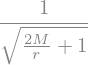

In [16]:
ks_alpha = 1 / sqrt(1 + 2 * M / r)
ks_alpha

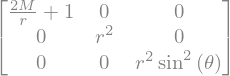

In [18]:
ks_metric = Matrix([
    [ 1 + (2 * M) / r, 0, 0],
    [ 0, r ** 2, 0 ],
    [ 0, 0, r ** 2 * sin(theta) ** 2 ],
])
ks_metric

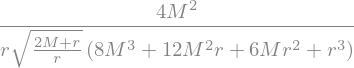

In [19]:
ks_lap = compute_laplacian(ks_alpha, ks_metric)
ks_lap

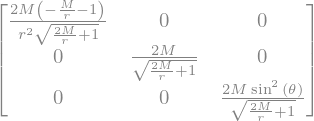

In [26]:
K_lo = ((2 * M * ks_alpha) / (r ** 2)) * Matrix([
    [ 1 - (2 + M / r), 0, 0 ],
    [ 0, r ** 2, 0 ],
    [ 0, 0, r ** 2 * sin(theta) ** 2 ],
])
K_lo

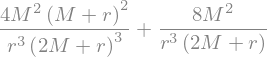

In [29]:
K_lo2 = Trace(K_lo * ks_metric.inv() * K_lo * ks_metric.inv()).simplify()
K_lo2

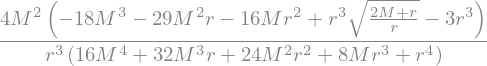

In [30]:
(ks_lap - K_lo2).simplify()